In [68]:
import numpy as np
from datetime import datetime as dt,timedelta
import xarray as xr
import netCDF4 as nc
import os
import copy
import matplotlib.colors as mcolors
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cftime
# import xesmf as xe
import matplotlib.pyplot as plt
from lib import driver
# from lib import plot 
from lib.tools import get_categorical_obs, get_categorical_fcst, get_heidke, get_rpss
# from lib import verif
from lib.tools import *
import pandas as pd
import xskillscore as xs

In [2]:
def check_lat_order(dataset,verbose=False):
    """
    Check the order of latitude coordinates in the dataset.
    
    Parameters:
    - dataset: xarray.Dataset or xarray.DataArray
    
    Returns:
    - True if latitude is ordered from North to South (N to S).
    - False if latitude is ordered from South to North (S to N).
    - None if the order is ambiguous or the dataset is empty.
    """
    if 'latitude' in dataset.coords:
        dataset = dataset.rename_dims({'latitude': 'lat', 'longitude': 'lon'})

    lat_coords = dataset['lat']
    lat_diff = lat_coords.diff(dim='lat')
    if verbose:
        print(lat_diff)

    if (lat_diff < 0.).all():
        dataset= dataset.sel(lat=dataset.lat[::-1])
        print('change latitude from S to N')
        # print(dataset.lat)
    elif (lat_diff > 0.).all():
        dataset = dataset
        print('====latitude from S to N----')
        # print(dataset.lat)
    else:
        print('!!!!!! Latitude ambiguous or unordered !!!!!!')
    return(dataset)

In [58]:
ds = xr.open_dataset('/home/ycheng/LIM/Scoring_John_code/cpc_data/cpc_anom_2019.nc')
ds = check_lat_order(ds)
ds
obs = ds['cpc_anom']

====latitude from S to N----


In [3]:
varname = 'T2m'
LIMpage_path = f'/Projects/jalbers_process/CPC_LIM/yuan_ming/CPC/Images_retrospective_8_vars_9e_sliding_climo_no_double_running_mean_add_offset_simple_map'
FCSTDIR = f'{LIMpage_path}/lim_t2m_retrospective/wk34separate_regression/offset/' 
VERIFDIR = f'{FCSTDIR}'
anomvar = varname+'_anom'
spreadvar = varname+'_spread' 

start_date = "2019-01-01"
end_date   = "2019-05-31"
date_range = pd.date_range(start=start_date, end=end_date)
files = [os.path.join(VERIFDIR, f'{varname}_offset.{date}.nc') for date in date_range.strftime('%Y%m%d')]
ds = xr.open_mfdataset(files)
ds = check_lat_order(ds,verbose=False)

for label,lt in zip(['wk34'],[(21,28)]):
    # new dataset with current lead time. if more than one, concatenate lead times
    newds = xr.concat([ds.sel(lead_time=f'{i} days') for i in lt],dim='lead_time').mean('lead_time')
    anom   = newds[anomvar]
    spread = newds[spreadvar]

change latitude from S to N


In [54]:
for date in date_range[0:1]:
    vCPC = xr.concat([obs.sel(time=date+timedelta(days=l)) for l in lt],dim='time').mean(dim='time')

    ANOM = anom.sel(time=date)
    SPREAD = spread.sel(time=date)

    vCPC   = xr.where(~ANOM.isnull() & ~vCPC.isnull() ,vCPC  ,np.nan)
    ANOM   = xr.where(~ANOM.isnull() & ~vCPC.isnull() ,ANOM  ,np.nan)
    SPREAD = xr.where(~vCPC.isnull() & ~SPREAD.isnull() ,SPREAD,np.nan)
    
    vCPC   = xr.where(SPREAD.isnull(),np.nan,vCPC)
    ANOM   = xr.where(vCPC.isnull()  ,np.nan,ANOM)
    SPREAD = xr.where(vCPC.isnull()  ,np.nan,SPREAD)

    vCPC   = np.array(vCPC)[vCPC.notnull()]
    ANOM   = np.array(ANOM)[ANOM.notnull()]
    SPREAD = np.array(SPREAD)[SPREAD.notnull()]


    bounds = [-np.inf*np.ones(len(vCPC)),np.zeros(len(vCPC)),np.inf*np.ones(len(vCPC))]
    OBS = get_categorical_obs((vCPC,),bounds)[0]
    bounds = [-np.inf*np.ones(len(ANOM)),np.zeros(len(ANOM)),np.inf*np.ones(len(ANOM))]
    PROB = get_categorical_fcst((ANOM,),(SPREAD,),bounds)[0]
    cat_fcst = PROB.T
    cat_obs  = OBS.T
    hits = np.sum(np.sum(cat_fcst*cat_obs,axis=1))
    N,C = cat_fcst.shape
    
    weights = np.ones(N)
    N = sum(weights)
    
    categorical = True
    print(cat_obs)
    print(cat_fcst)
    print(cat_obs.shape)
    print(cat_fcst.shape)
    if categorical:
        cat_fcst = np.round(cat_fcst)
    print(cat_fcst)
    if N==0:
        H1 = 0
    else:
        H1 = N**-1 * np.sum(np.sum(cat_fcst*cat_obs,axis=1)*weights)
    H2 = 1/C
#    H2 = N**-2 * np.sum(np.sum((cat_fcst*cat_obs+(1-cat_fcst)*cat_obs)*weights[:,None],axis=1)*
#                       np.sum((cat_fcst*cat_obs+cat_fcst*(1-cat_obs))*weights[:,None],axis=1))
    HSS = (H1 - H2) / (1 - H2)
    HSS_2 = get_heidke(PROB.T,OBS.T,categorical=True)
    print(HSS,HSS_2)
#     skill.append(HSS)
    print(vCPC.shape)
    print(ANOM.shape)
    print(PROB.shape)
    print('vCPC:', vCPC[0:20])
    print('ANOM:',ANOM[0:20])
    print('cat_fcst:', cat_fcst[0:20])
    print('cat_obs',cat_obs[0:20])
    # print(PROB[0][0])
    multiplication = cat_fcst*cat_obs
    print('multiplication',multiplication[0:20])
    # print((cat_fcst*cat_obs).shape)
    print('sum',np.sum(cat_fcst*cat_obs,axis=1)[0:20])


[[False  True]
 [False  True]
 [False  True]
 ...
 [False  True]
 [False  True]
 [ True False]]
[[0.38606221 0.61393779]
 [0.3605475  0.6394525 ]
 [0.3402959  0.6597041 ]
 ...
 [0.35040156 0.64959844]
 [0.34263167 0.65736833]
 [0.2648879  0.7351121 ]]
(693, 2)
(693, 2)
[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]
0.4545454545454546 0.4545454545454546
(693,)
(693,)
(2, 693)
vCPC: [ 2.3006744   1.5604553   2.440105    0.68184555 -1.1301793  -0.7203849
  0.43824983  1.160806    0.59903175 -0.23971558 -0.4666639  -0.05189514
  1.1588309   1.3595036   1.0805686   0.49445012 -0.1608756  -0.52076286
  1.5721893   0.7065582 ]
ANOM: [ 0.29401222  0.40167356  0.5074975  -0.04454565  0.03907806  0.09459484
 -0.43705225  0.18341203  0.12389901 -0.03120705 -0.22803088 -0.21548001
  0.28212085  0.13959002 -0.05678168 -0.0494462  -0.00705289 -0.35120118
  0.40935427  0.6609683 ]
cat_fcst: [[0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]

In [82]:
# probability_bin_edges=np.array([0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95, 1.05])
# obs_list = []
# fcst_list = []
# for date in date_range:
#     vCPC = xr.concat([obs.sel(time=date+timedelta(days=l)) for l in lt],dim='time').mean(dim='time')

#     ANOM = anom.sel(time=date)
#     SPREAD = spread.sel(time=date)

#     vCPC   = xr.where(~ANOM.isnull() & ~vCPC.isnull() ,vCPC  ,np.nan)
#     ANOM   = xr.where(~ANOM.isnull() & ~vCPC.isnull() ,ANOM  ,np.nan)
#     SPREAD = xr.where(~vCPC.isnull() & ~SPREAD.isnull() ,SPREAD,np.nan)
    
#     vCPC   = xr.where(SPREAD.isnull(),np.nan,vCPC)
#     ANOM   = xr.where(vCPC.isnull()  ,np.nan,ANOM)
#     SPREAD = xr.where(vCPC.isnull()  ,np.nan,SPREAD)

#     vCPC   = np.array(vCPC)[vCPC.notnull()]
#     ANOM   = np.array(ANOM)[ANOM.notnull()]
#     SPREAD = np.array(SPREAD)[SPREAD.notnull()]

    
#     bounds = [-np.inf*np.ones(len(vCPC)),np.zeros(len(vCPC)),np.inf*np.ones(len(vCPC))]
#     OBS = get_categorical_obs((vCPC,),bounds)[0]
#     bounds = [-np.inf*np.ones(len(ANOM)),np.zeros(len(ANOM)),np.inf*np.ones(len(ANOM))]
#     PROB = get_categorical_fcst((ANOM,),(SPREAD,),bounds)[0]
#     cat_fcst = PROB.T
#     cat_obs  = OBS.T
#     obs_reliability = cat_obs[:,0]
#     fcst_reliability = cat_fcst[:,0] 
#     obs_list.append(obs_reliability)
#     fcst_list.append(fcst_reliability)



In [95]:
dims = ('time','point')
coords = {'time': date_range,'point':np.arange(np.array(obs_list).shape[1])}


ds_obs  = xr.DataArray(obs_list , dims=dims,coords=coords)
ds_fcst = xr.DataArray(fcst_list, dims=dims,coords=coords)


'/Projects/jalbers_process/CPC_LIM/yuan_ming/CPC/Images_retrospective_8_vars_9e_sliding_climo_no_double_running_mean_add_offset_simple_map/lim_t2m_retrospective/wk34separate_regression/offset//verification'

In [96]:
reliability = xs.reliability(ds_obs,ds_fcst,probability_bin_edges=probability_bin_edges)

/home/ycheng/.conda/envs/cpc/lib/python3.10/site-packages/xskillscore/core/np_probabilistic.py:39: RuntimeWarning: invalid value encountered in scalar divide
  r[..., i] = N_o_f_in_bin / N_f_in_bin


In [97]:
print(reliability)

<xarray.DataArray (forecast_probability: 10)>
array([0.42348754, 0.38413838, 0.30299675, 0.4644867 , 0.52461322,
       0.49162345, 0.36090591, 0.1206544 , 0.        ,        nan])
Coordinates:
  * forecast_probability  (forecast_probability) float64 0.1 0.2 0.3 ... 0.9 1.0
    samples               (forecast_probability) float64 281.0 3.064e+03 ... 0.0


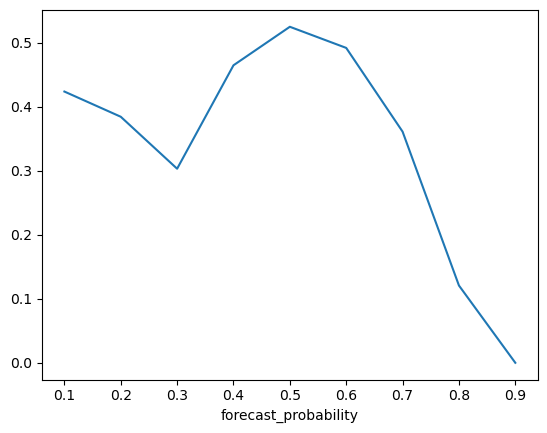

In [98]:
reliability.plot()